# Import Needed Packages

In [1]:
import tensorflow as tf  # models
import numpy as np  # math computations
import matplotlib.pyplot as plt  # plots
import sklearn  # machine learning library
import cv2  # image processing
from sklearn.metrics import confusion_matrix, roc_curve  # metrics
import seaborn as sns  # visualizations
import datetime
import io
import os
import random
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp

# Data Preparation

## Data Loading


In [2]:
download_path = r"C:\Users\Elwaly\Downloads\Malaria"
tfds.download.add_checksums_dir(download_path)
# Load the malaria dataset
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  data_dir=download_path,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split=['train'])

In [3]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\Elwaly\\Downloads\\Malaria\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
dataset_path = r"C:\Users\Elwaly\Downloads\Malaria\train"

# Create an ImageDataGenerator with validation split
data_generator = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    validation_split=0.2
)

# Create a generator for the training set
train_dataset = data_generator.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    subset="training"  # Use the "training" subset for training data
)

# Create a generator for the original validation set
validation_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    subset="validation"  # Use the "validation" subset for validation data
)

Found 17639 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.


In [6]:
test_path = r"C:\Users\Elwaly\Downloads\Malaria\test"

test_generator = ImageDataGenerator()
test = test_generator.flow_from_directory(
    test_path,
    target_size=(64, 64),
    class_mode="binary",
    batch_size=32,
    shuffle=True,)

Found 5511 images belonging to 2 classes.


## Sequential API

In [7]:
DROPOUT_RATE = 0.1
REGULARIZATION_RATE = 0.01
N_FILTERS = 32
KERNEL_SIZE = 3
POOL_SIZE = 2
N_STRIDES = 1
IM_SIZE = 64
BATCH_SIZE = 32

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    

    Conv2D(filters = N_FILTERS, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),
    
    Conv2D(filters = N_FILTERS, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Flatten(),
    
    Dense(128, activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense(128, activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 32)        128       
 chNormalization)                                                
                                                        

In [8]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

lenet_model.compile(optimizer = Adam(learning_rate = 0.0005),
      loss = BinaryCrossentropy(), metrics = metrics)


In [14]:
history = lenet_model.fit(train_dataset, validation_data=validation_generator, epochs=50, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/50



552/552 [==============================] - 153s 234ms/step - loss: 2.7090 - tp: 6630.0000 - fp: 3120.0000 - tn: 5700.0000 - fn: 2189.0000 - accuracy: 0.6990 - precision: 0.6800 - recall: 0.7518 - auc: 0.7700 - val_loss: 1.6528 - val_tp: 2198.0000 - val_fp: 2068.0000 - val_tn: 136.0000 - val_fn: 6.0000 - val_accuracy: 0.5295 - val_precision: 0.5152 - val_recall: 0.9973 - val_auc: 0.6951
Epoch 2/50
552/552 [==============================] - 126s 227ms/step - loss: 0.8755 - tp: 8210.0000 - fp: 2137.0000 - tn: 6683.0000 - fn: 609.0000 - accuracy: 0.8443 - precision: 0.7935 - recall: 0.9309 - auc: 0.9019 - val_loss: 0.6519 - val_tp: 1965.0000 - val_fp: 422.0000 - val_tn: 1782.0000 - val_fn: 239.0000 - val_accuracy: 0.8500 - val_precision: 0.8232 - val_recall: 0.8916 - val_auc: 0.9209
Epoch 3/50
552/552 [==============================] - 128s 232ms/step - loss: 0.5295 - tp: 8312.0000 - fp: 1862.0000 - tn: 6958.0000 - fn: 507.0000 - accuracy: 0.8657 - precision: 0.8170 - recall: 0.9425 - auc:


























































































































































































































































































































































## Callbacks

In [10]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))
    
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [11]:
class LogImagesCallbackTensorBoard(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)
    
    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)
    
    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)

In [12]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y_%H%M%S')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [13]:
LOG_DIR = './logs/'+ CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

## Visualizations

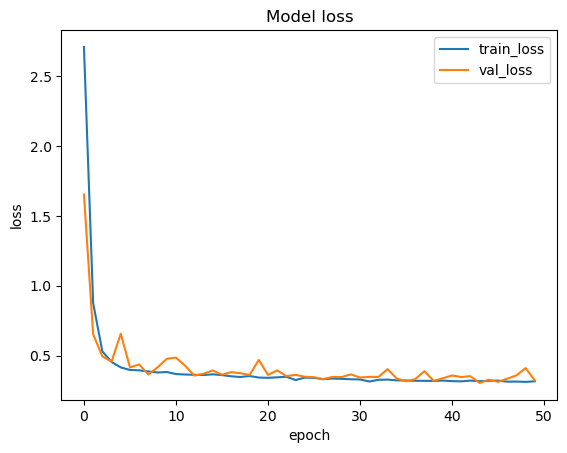

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.savefig('Sequential_LossVal_loss')
plt.show()

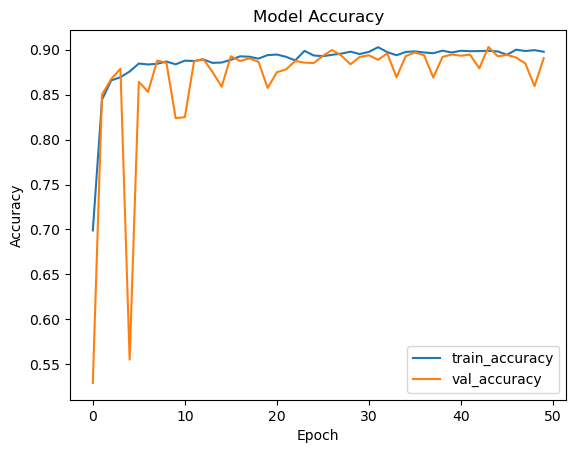

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.savefig('Sequential_AccVal_ac')
plt.show()


In [18]:
print(lenet_model.evaluate(train_dataset)) 

552/552 [==============================] - 96s 174ms/step - loss: 0.3084 - tp: 8576.0000 - fp: 1534.0000 - tn: 7286.0000 - fn: 243.0000 - accuracy: 0.8993 - precision: 0.8483 - recall: 0.9724 - auc: 0.9548
[0.30844709277153015, 8576.0, 1534.0, 7286.0, 243.0, 0.8992573022842407, 0.8482690453529358, 0.9724458456039429, 0.9548307061195374]


In [17]:
#testing  on test set
print(lenet_model.evaluate(test)) 

173/173 [==============================] - 9s 52ms/step - loss: 47.1089 - tp: 2709.0000 - fp: 704.0000 - tn: 2051.0000 - fn: 47.0000 - accuracy: 0.8637 - precision: 0.7937 - recall: 0.9829 - auc: 0.8644
[47.10886001586914, 2709.0, 704.0, 2051.0, 47.0, 0.8637270927429199, 0.793729841709137, 0.9829462766647339, 0.8643512725830078]


### ModelCheckpointing

In [335]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

## Hyperparameter Tuning

In [336]:
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
      
    Flatten(),
    
    Dense( hparams[HP_NUM_UNITS_1], activation = "relu"),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),
    
    Dense(hparams[HP_NUM_UNITS_2], activation = "relu"),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=2)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [252]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
#HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))


In [253]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      #for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              #HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,
              
          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], #hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

Epoch 1/2
87/87 [==============================] - 19s 166ms/step - loss: 0.7124 - accuracy: 0.6174
Epoch 2/2
87/87 [==============================] - 6s 43ms/step - loss: 0.7230 - accuracy: 0.4929
For the run 0, hparams num_units_1:32, num_units_2:32, dropout:0.1, learning_rate:0.0001
Epoch 1/2
87/87 [==============================] - 19s 166ms/step - loss: 0.6439 - accuracy: 0.6407
Epoch 2/2
87/87 [==============================] - 6s 43ms/step - loss: 1.3077 - accuracy: 0.5085
For the run 1, hparams num_units_1:32, num_units_2:32, dropout:0.1, learning_rate:0.001
Epoch 1/2
87/87 [==============================] - 19s 166ms/step - loss: 0.7130 - accuracy: 0.6011
Epoch 2/2
87/87 [==============================] - 6s 43ms/step - loss: 0.7297 - accuracy: 0.4929
For the run 2, hparams num_units_1:32, num_units_2:32, dropout:0.2, learning_rate:0.0001
Epoch 1/2
87/87 [==============================] - 21s 172ms/step - loss: 0.6996 - accuracy: 0.6145
Epoch 2/2
87/87 [=======================

## Visualizations using tensorboard

In [386]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [387]:
tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 1364), started 17:38:14 ago. (Use '!kill 1364' to kill it.)

# Saving the model

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
new_model.save('model_Sequential.h5')

In [ ]:
model=load_model('model_Sequential.h5')

In [ ]:
img=image.load_img(r"C:\Users\Elwaly\Downloads\Malaria\cell_images\Uninfected\C184P145ThinF_IMG_20151203_104153_cell_96.png", target_size=(64,64,3))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
model.predict(x)

In [ ]:
for i in model.predict(x):
    if(int(i)==1):
        print("Uninfected")
    else:
        print("Infected")